In [170]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import genpareto
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import QuantileRegressor
from geopy.distance import geodesic
import itertools
from statsmodels.stats.outliers_influence import variance_inflation_factor
import lightgbm as lgb
import shap


In [ ]:
asset_impact = pd.read_parquet('/Users/user/Documents/GitHub/Thesis_2425/Data/agg_asset_results.parquet', engine='pyarrow')
firm_impact = pd.read_parquet('/Users/user/Documents/GitHub/Thesis_2425/Data/agg_firm_results.parquet', engine='pyarrow')
ownership = pd.read_excel('/Users/user/Documents/GitHub/Thesis_2425/Data/coal_supply_chain_india_updated2.xlsx', sheet_name="ownership")
supply_chain = pd.read_excel('/Users/user/Documents/GitHub/Thesis_2425/Data/coal_supply_chain_india_updated2.xlsx', sheet_name="supply chain")
assets = pd.read_excel('/Users/user/Documents/GitHub/Thesis_2425/Data/coal_supply_chain_india_updated2.xlsx', sheet_name="assets")
firms = pd.read_excel('/Users/user/Documents/GitHub/Thesis_2425/Data/coal_supply_chain_india_updated2.xlsx', sheet_name="firms")

In [172]:
# Calculate firm-level VaR & ES
firm_risk = firm_impact.groupby("firm")["impact"].agg([
    ("VaR_95", lambda x: np.percentile(x, 5)),
    ("VaR_99", lambda x: np.percentile(x, 1)),
    ("ES_95", lambda x: x[x <= np.percentile(x, 5)].mean()),
    ("ES_99", lambda x: x[x <= np.percentile(x, 1)].mean()),
]).reset_index()


In [ ]:
# firm_name mapping — asset_name → asset_id → firm_id → firm_name
assets = assets.rename(columns={"name": "asset_name"})
firms = firms.rename(columns={"name": "firm_name"})

# asset_name → asset_id
asset_impact = asset_impact.merge(assets, left_on="asset", right_on="asset_name", how="left")

# asset_id → firm_id
asset_impact = asset_impact.merge(ownership, on="asset_id", how="left")

# firm_id → firm_name
asset_impact = asset_impact.merge(firms, on="firm_id", how="left")

# Build supply chain graph and calculate in-degree / out-degree
G = nx.DiGraph()

# build directed graph using 'supplier' and 'client' columns
edges = supply_chain[["supplier", "client"]]
edges = edges.astype(int)
G.add_edges_from(edges.values)

# calculate in-degree and out-degree for each company in the network
in_deg_dict = dict(G.in_degree())
out_deg_dict = dict(G.out_degree())

degree_df = pd.DataFrame({
    "firm_id": list(set(in_deg_dict) | set(out_deg_dict)),
    "in_degree": [in_deg_dict.get(fid, 0) for fid in set(in_deg_dict) | set(out_deg_dict)],
    "out_degree": [out_deg_dict.get(fid, 0) for fid in set(in_deg_dict) | set(out_deg_dict)]
})

# add firm_name for merging
degree_df = degree_df.merge(firms[["firm_id", "firm_name"]], on="firm_id", how="left")

In [ ]:
# Compute base statistics per firm
firm_structure = asset_impact.groupby("firm_name").agg({
    "asset": "count",
    "impact": ["max", "mean", "std"],
    "latitude": lambda x: x.astype(str).str.replace(",", ".").astype(float).std(),
    "longitude": lambda x: x.astype(str).str.replace(",", ".").astype(float).std()
})

firm_structure.columns = [
    "num_assets", 
    "max_asset_impact", 
    "mean_asset_impact", 
    "std_asset_impact",
    "lat_std", 
    "lon_std"
]

# Create geographic dispersion indicator
firm_structure["geo_dispersion_std"] = (firm_structure["lat_std"]**2 + firm_structure["lon_std"]**2)**0.5

# Clean and format
firm_structure["num_assets"] = (firm_structure["num_assets"] / 100).astype(int)
firm_structure = firm_structure.reset_index()
firm_structure = firm_structure.drop(columns=["lat_std", "lon_std"])

In [ ]:
# Merge risk indicators with structural variables
df_model = firm_risk.merge(firm_structure, left_on="firm", right_on="firm_name", how="left")
df_model.drop(columns=["firm_name"], inplace=True)


# Merge in/out degree into the model data
df_model = df_model.merge(degree_df[["firm_name", "in_degree", "out_degree"]],
                          left_on="firm", right_on="firm_name", how="left")
# Standardization
features = ["num_assets", "max_asset_impact", "geo_dispersion_std", "in_degree", "out_degree"]
scaler = StandardScaler()
df_model[features] = scaler.fit_transform(df_model[features])

In [176]:
df_model

,firm,VaR_95,VaR_99,ES_95,ES_99,num_assets,max_asset_impact,mean_asset_impact,std_asset_impact,geo_dispersion_std,firm_name,in_degree,out_degree
0,-,-0.000035,-0.102024,-0.061404,-0.102221,-0.252587,-0.195145,-0.003070,0.015931,-0.789955,-,-0.706245,0.976125
1,ACB (India),-0.000300,-0.012183,-0.010528,-0.020380,-0.102706,-0.195145,-0.001195,0.011870,-0.667952,ACB (India),-0.540549,-0.775158
2,AM/NS,0.000000,0.000000,0.000000,0.000000,-0.252587,-0.195145,0.000000,0.000000,-0.789955,AM/NS,-0.706245,0.100483
3,APM Terminals,0.000000,0.000000,0.000000,0.000000,-0.252587,-0.195145,0.000000,0.000000,-0.789955,APM Terminals,-0.706245,0.100483
4,ARS Steels & Alloy International Pvt,-0.147702,-1.000000,-0.675947,-1.000000,-0.252587,-0.195145,-0.036947,0.173428,-0.789955,ARS Steels & Alloy International Pvt,-0.043461,-0.775158
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,UltraTech Cement,0.000000,-1.000000,-0.030068,-1.000000,-0.222611,-0.195145,-0.030208,0.171004,0.636667,UltraTech Cement,0.122235,-0.775158
57,V.O. Chidambaranar Port Trust,0.000000,0.000000,0.000000,0.000000,-0.252587,-0.195145,0.000000,0.000000,-0.789955,V.O. Chidambaranar Port Trust,-0.706245,0.450740
58,Vedanta Inc,-0.004659,-1.000000,-0.633013,-1.000000,-0.012777,-0.050294,-0.023734,0.147657,1.869872,Vedanta Inc,1.779195,-0.775158
59,Visakhapatnam Port Trust,0.000000,0.000000,0.000000,0.000000,-0.252587,-0.195145,0.000000,0.000000,-0.789955,Visakhapatnam Port Trust,-0.706245,1.151254


### 3 Plot tail risks distributions of firm

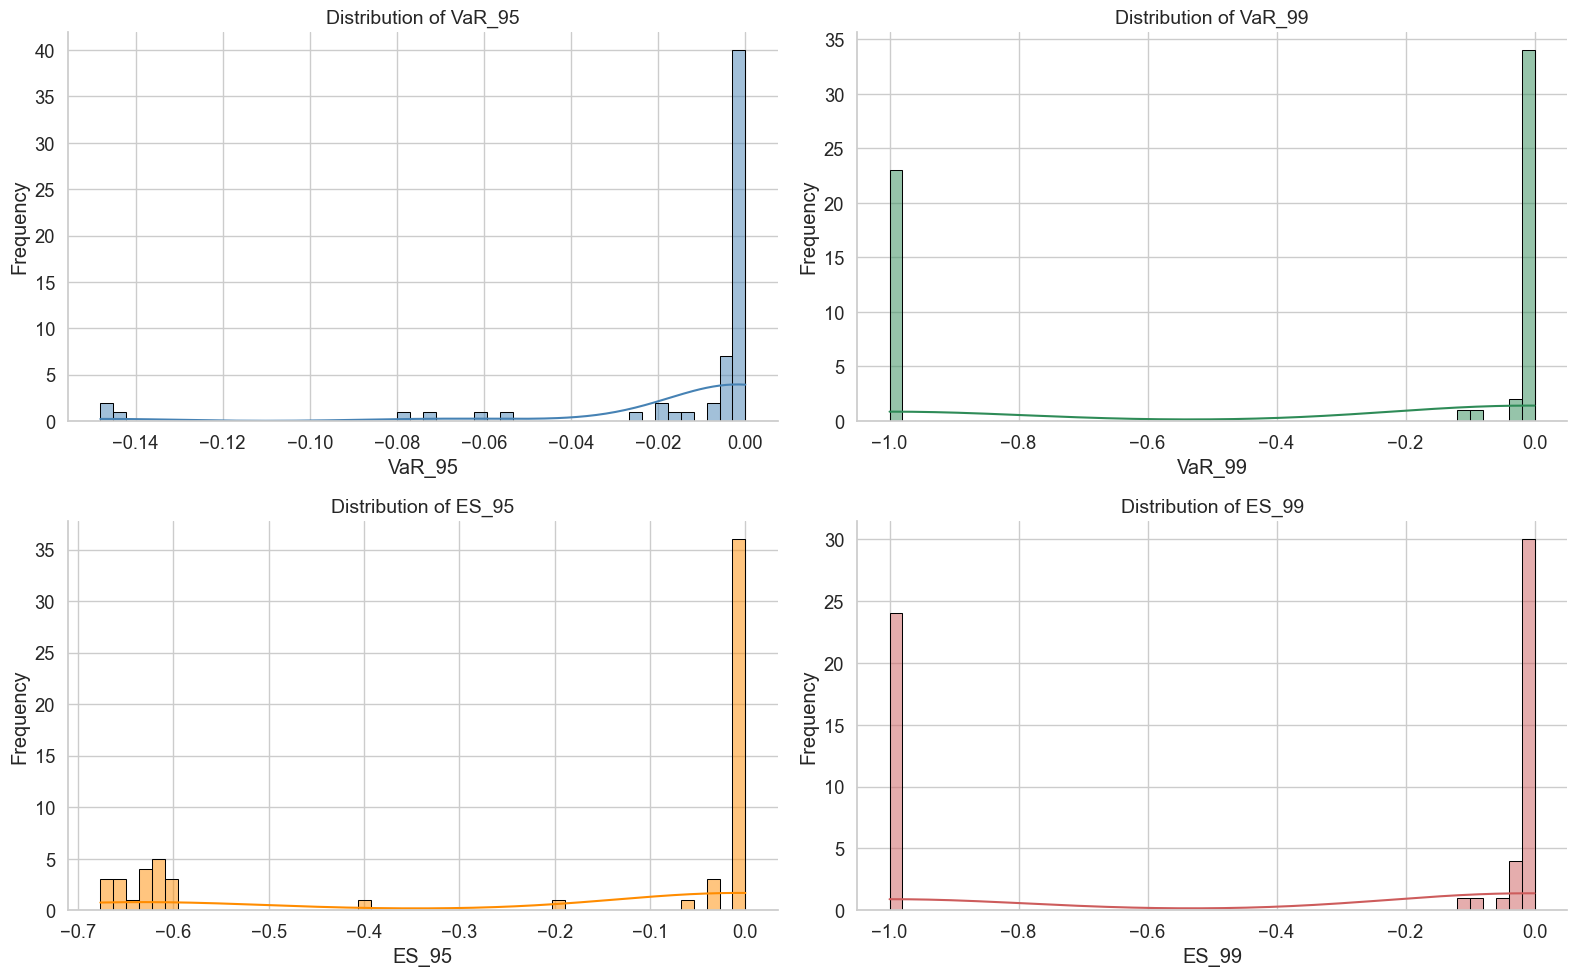

In [177]:
# Set style for consistency and clarity
sns.set(style="whitegrid", font_scale=1.2)

# Define the columns and titles
metrics = ["VaR_95", "VaR_99", "ES_95", "ES_99"]
titles = ["Distribution of VaR_95", "Distribution of VaR_99",
          "Distribution of ES_95", "Distribution of ES_99"]
colors = ["steelblue", "seagreen", "darkorange", "indianred"]

# Create 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for i, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
    row, col = divmod(i, 2)
    sns.histplot(df_model[metric].dropna(), bins=50, kde=True,
                 color=color, ax=axes[row][col], edgecolor='black')
    axes[row][col].set_title(title, fontsize=14)
    axes[row][col].set_xlabel(metric)
    axes[row][col].set_ylabel("Frequency")
    axes[row][col].spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

## Classic Quantile Regression

### Check multicollinearity

In [178]:
# `features` is already defined
X = df_model[features].copy()

# Create a DataFrame to store VIF values
vif_df = pd.DataFrame()
vif_df["feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the result
vif_df


,feature,VIF
0,num_assets,1.496861
1,max_asset_impact,1.032533
2,geo_dispersion_std,1.183375
3,in_degree,1.160786
4,out_degree,1.509651


VIF values are all below 2, therefore all features are reasonably independent from one another.

/var/folders/wy/k_hfp9ls0msf61dg9qbm3h040000gn/T/ipykernel_32458/3129902757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="VIF", y="feature", data=vif_df_sorted, palette="viridis", edgecolor='black')


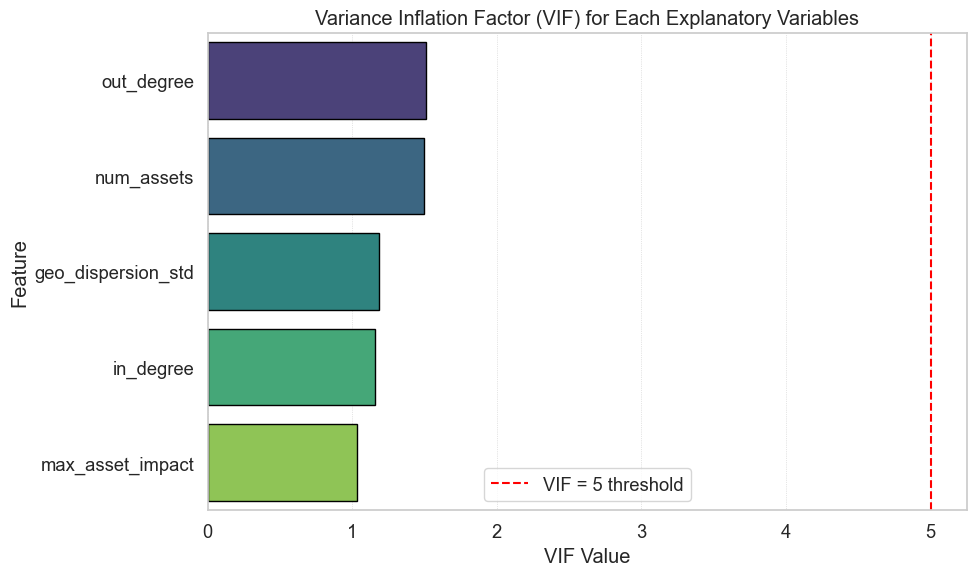

In [179]:
# Sort the VIF values for better visual clarity
vif_df_sorted = vif_df.sort_values(by="VIF", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="VIF", y="feature", data=vif_df_sorted, palette="viridis", edgecolor='black')

# Add a dashed vertical line at VIF=5
plt.axvline(x=5, color='red', linestyle='--', label='VIF = 5 threshold')

# Add labels and title
plt.title("Variance Inflation Factor (VIF) for Each Explanatory Variables")
plt.xlabel("VIF Value")
plt.ylabel("Feature")
plt.legend()
plt.grid(True, axis='x', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

### 0.5 Quantile

In [180]:
# Fit the model at the 0.5 quantile (median)
model_VaR_99_5 = smf.quantreg("VaR_99 ~ num_assets + geo_dispersion_std + max_asset_impact + in_degree + out_degree", data=df_model)
res_VaR_99_5 = model_VaR_99_5.fit(q=0.5, cov_type="kernel")

# Display the summary
print(res_VaR_99_5.summary())


                         QuantReg Regression Results                          
Dep. Variable:                 VaR_99   Pseudo R-squared:               0.4918
Model:                       QuantReg   Bandwidth:                      0.1245
Method:                 Least Squares   Sparsity:                       0.2680
Date:                Sun, 01 Jun 2025   No. Observations:                   61
Time:                        18:45:57   Df Residuals:                       55
                                        Df Model:                            5
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.2966      0.017    -17.290      0.000      -0.331      -0.262
num_assets            -0.0034      0.021     -0.162      0.872      -0.045       0.039
geo_dispersion_std     0.0171      0.019      0.915      0.364      -0.020       0.054
max_asset_im

In [181]:
model_VaR_95_5 = smf.quantreg("VaR_95 ~ num_assets + geo_dispersion_std + max_asset_impact  + in_degree + out_degree", data=df_model)
res_VaR_95_5 = model_VaR_95_5.fit(q=0.5, cov_type="kernel")
print(res_VaR_95_5.summary())

                         QuantReg Regression Results                          
Dep. Variable:                 VaR_95   Pseudo R-squared:              0.05088
Model:                       QuantReg   Bandwidth:                    0.001318
Method:                 Least Squares   Sparsity:                     0.002943
Date:                Sun, 01 Jun 2025   No. Observations:                   61
Time:                        18:45:57   Df Residuals:                       55
                                        Df Model:                            5
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0018      0.000     -9.606      0.000      -0.002      -0.001
num_assets         -4.517e-05      0.000     -0.196      0.845      -0.001       0.000
geo_dispersion_std -2.447e-05      0.000     -0.119      0.905      -0.000       0.000
max_asset_im

In [182]:
model_ES_99_5 = smf.quantreg("ES_99 ~ num_assets + geo_dispersion_std + max_asset_impact  + in_degree + out_degree", data=df_model)
res_ES_99_5 = model_ES_99_5.fit(q=0.5, cov_type="kernel")
print(res_ES_99_5.summary())

                         QuantReg Regression Results                          
Dep. Variable:                  ES_99   Pseudo R-squared:               0.4792
Model:                       QuantReg   Bandwidth:                      0.1451
Method:                 Least Squares   Sparsity:                       0.3042
Date:                Sun, 01 Jun 2025   No. Observations:                   61
Time:                        18:45:57   Df Residuals:                       55
                                        Df Model:                            5
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.3013      0.019    -15.472      0.000      -0.340      -0.262
num_assets            -0.0028      0.024     -0.119      0.906      -0.051       0.045
geo_dispersion_std     0.0123      0.021      0.582      0.563      -0.030       0.055
max_asset_im

In [183]:
model_ES_95_5 = smf.quantreg("ES_95 ~ num_assets + geo_dispersion_std + max_asset_impact  + in_degree + out_degree", data=df_model)
res_ES_95_5 = model_ES_95_5.fit(q=0.5, cov_type="kernel")
print(res_ES_95_5.summary())

                         QuantReg Regression Results                          
Dep. Variable:                  ES_95   Pseudo R-squared:               0.4680
Model:                       QuantReg   Bandwidth:                     0.04085
Method:                 Least Squares   Sparsity:                      0.09453
Date:                Sun, 01 Jun 2025   No. Observations:                   61
Time:                        18:45:57   Df Residuals:                       55
                                        Df Model:                            5
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.1737      0.006    -28.699      0.000      -0.186      -0.162
num_assets             0.0036      0.007      0.489      0.627      -0.011       0.018
geo_dispersion_std     0.0067      0.007      1.011      0.316      -0.007       0.020
max_asset_im

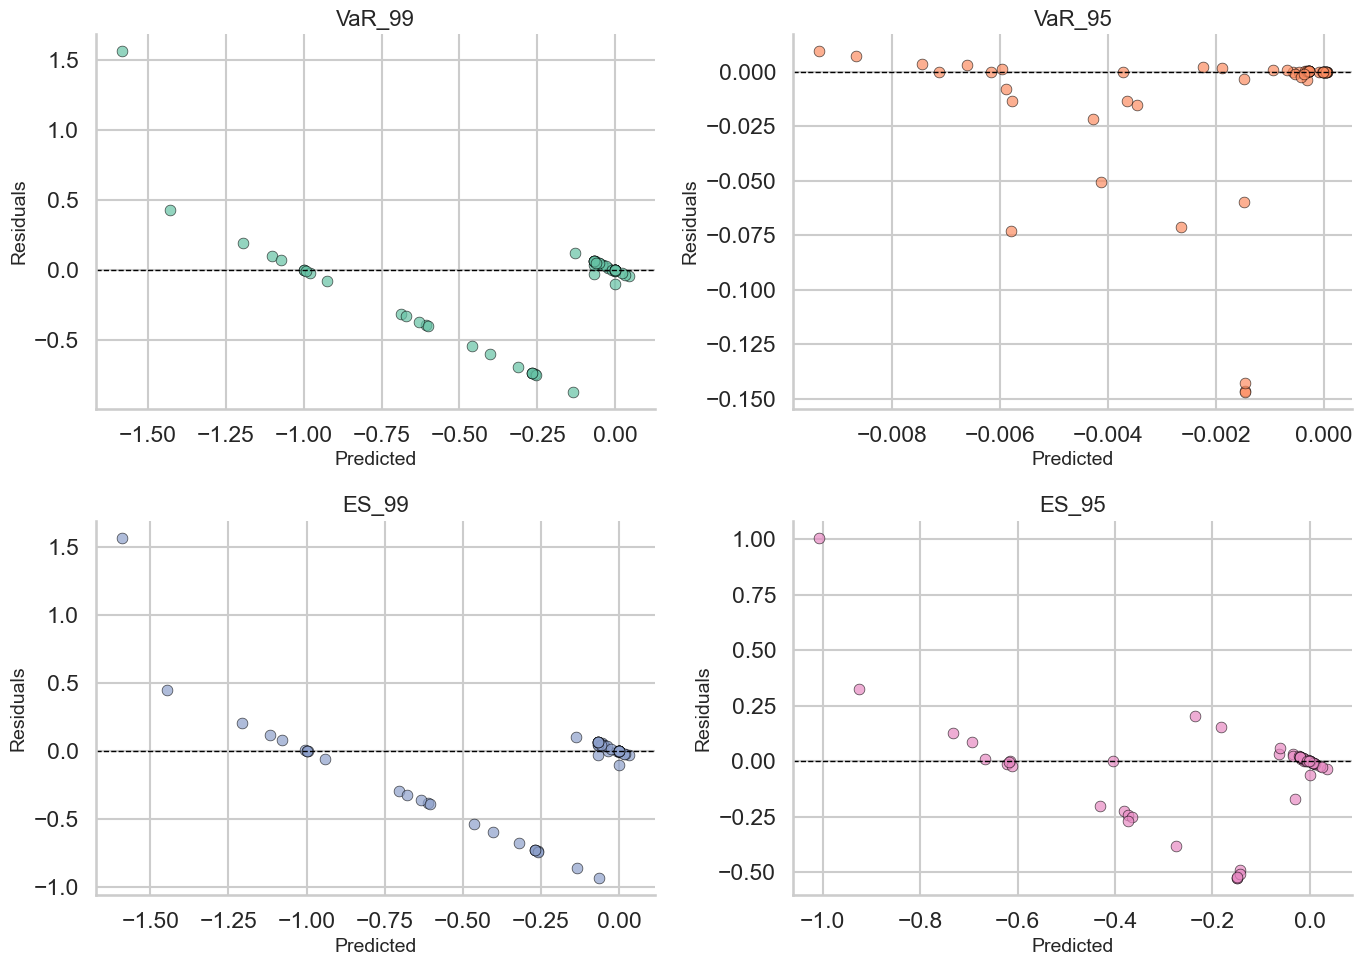

In [184]:
# Set Seaborn style and context
sns.set(style="whitegrid", context="talk")

# Choose a vibrant color palette
palette = sns.color_palette("Set2", 4)

# Dictionary of target variables and corresponding fitted models
targets = {
    "VaR_99": res_VaR_99_5,
    "VaR_95": res_VaR_95_5,
    "ES_99": res_ES_99_5,
    "ES_95": res_ES_95_5
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (ax, (target_name, model)) in enumerate(zip(axes, targets.items())):
    y_true = df_model[target_name]
    y_pred = model.predict(df_model)
    residuals = y_true - y_pred

    ax.scatter(
        y_pred, residuals,
        alpha=0.7, s=60,
        edgecolor="black", linewidth=0.5,
        color=palette[idx]
    )
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax.set_title(f"{target_name}", fontsize=16)
    ax.set_xlabel("Predicted", fontsize=14)
    ax.set_ylabel("Residuals", fontsize=14)
    sns.despine(ax=ax)

plt.tight_layout()
plt.show()

### 0.1 quantile

In [185]:
model_VaR_99_1 = smf.quantreg("VaR_99 ~ num_assets + geo_dispersion_std + max_asset_impact + in_degree + out_degree", data=df_model)
res_VaR_99_1 = model_VaR_99_1.fit(q=0.1, cov_type="kernel")
print(res_VaR_99_1.summary())

                         QuantReg Regression Results                          
Dep. Variable:                 VaR_99   Pseudo R-squared:               0.2237
Model:                       QuantReg   Bandwidth:                      0.6293
Method:                 Least Squares   Sparsity:                        1.668
Date:                Sun, 01 Jun 2025   No. Observations:                   61
Time:                        18:45:58   Df Residuals:                       55
                                        Df Model:                            5
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.8324      0.072    -11.496      0.000      -0.978      -0.687
num_assets            -0.0884      0.070     -1.256      0.215      -0.229       0.053
geo_dispersion_std     0.0144      0.081      0.177      0.860      -0.148       0.177
max_asset_im

In [186]:
model_VaR_95_1 = smf.quantreg("VaR_95 ~ num_assets + geo_dispersion_std + max_asset_impact  + in_degree + out_degree", data=df_model)
res_VaR_95_1 = model_VaR_95_1.fit(q=0.1, cov_type="kernel")
print(res_VaR_95_1.summary())

                         QuantReg Regression Results                          
Dep. Variable:                 VaR_95   Pseudo R-squared:               0.2047
Model:                       QuantReg   Bandwidth:                     0.04711
Method:                 Least Squares   Sparsity:                       0.1509
Date:                Sun, 01 Jun 2025   No. Observations:                   61
Time:                        18:45:58   Df Residuals:                       55
                                        Df Model:                            5
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0456      0.007     -6.600      0.000      -0.059      -0.032
num_assets            -0.0085      0.007     -1.186      0.241      -0.023       0.006
geo_dispersion_std     0.0079      0.007      1.057      0.295      -0.007       0.023
max_asset_im

In [187]:
model_ES_99_1 = smf.quantreg("ES_99 ~ num_assets + geo_dispersion_std + max_asset_impact  + in_degree + out_degree", data=df_model)
res_ES_99_1 = model_ES_99_1.fit(q=0.1, cov_type="kernel")
print(res_ES_99_1.summary())

                         QuantReg Regression Results                          
Dep. Variable:                  ES_99   Pseudo R-squared:              0.08073
Model:                       QuantReg   Bandwidth:                      0.6471
Method:                 Least Squares   Sparsity:                        1.723
Date:                Sun, 01 Jun 2025   No. Observations:                   61
Time:                        18:45:58   Df Residuals:                       55
                                        Df Model:                            5
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.8383      0.079    -10.619      0.000      -0.996      -0.680
num_assets            -0.0810      0.073     -1.104      0.274      -0.228       0.066
geo_dispersion_std     0.0168      0.082      0.205      0.838      -0.147       0.181
max_asset_im

In [188]:
model_ES_95_1 = smf.quantreg("ES_95 ~ num_assets + geo_dispersion_std + max_asset_impact  + in_degree + out_degree", data=df_model)
res_ES_95_1 = model_ES_95_1.fit(q=0.1, cov_type="kernel")
print(res_ES_95_1.summary())

                         QuantReg Regression Results                          
Dep. Variable:                  ES_95   Pseudo R-squared:               0.2640
Model:                       QuantReg   Bandwidth:                      0.3903
Method:                 Least Squares   Sparsity:                        1.131
Date:                Sun, 01 Jun 2025   No. Observations:                   61
Time:                        18:45:58   Df Residuals:                       55
                                        Df Model:                            5
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.5190      0.052    -10.014      0.000      -0.623      -0.415
num_assets            -0.0578      0.054     -1.070      0.289      -0.166       0.051
geo_dispersion_std     0.0021      0.055      0.038      0.970      -0.109       0.113
max_asset_im

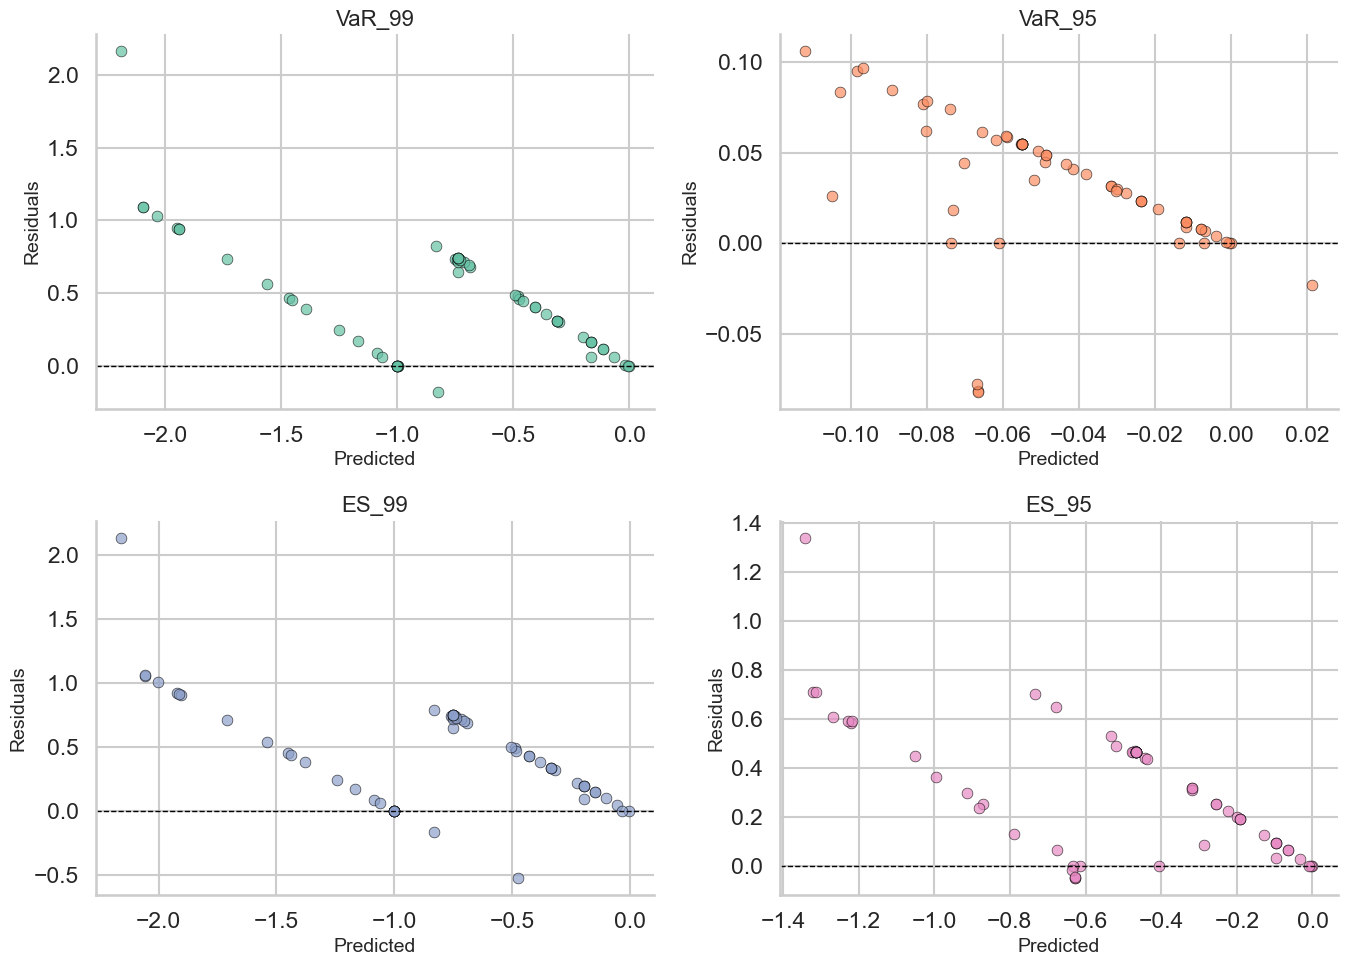

In [189]:
# Set Seaborn style and context
sns.set(style="whitegrid", context="talk")

# Choose a vibrant color palette
palette = sns.color_palette("Set2", 4)

# Dictionary of target variables and corresponding fitted models
targets = {
    "VaR_99": res_VaR_99_1,
    "VaR_95": res_VaR_95_1,
    "ES_99": res_ES_99_1,
    "ES_95": res_ES_95_1
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (ax, (target_name, model)) in enumerate(zip(axes, targets.items())):
    y_true = df_model[target_name]
    y_pred = model.predict(df_model)
    residuals = y_true - y_pred

    ax.scatter(
        y_pred, residuals,
        alpha=0.7, s=60,
        edgecolor="black", linewidth=0.5,
        color=palette[idx]
    )
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax.set_title(f"{target_name}", fontsize=16)
    ax.set_xlabel("Predicted", fontsize=14)
    ax.set_ylabel("Residuals", fontsize=14)
    sns.despine(ax=ax)

plt.tight_layout()
plt.show()

## LightGBM Quantile Regression

[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 61
[LightGBM] [Info] Number of data points in the train set: 61, number of used features: 5
[LightGBM] [Info] Start training from score -1.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

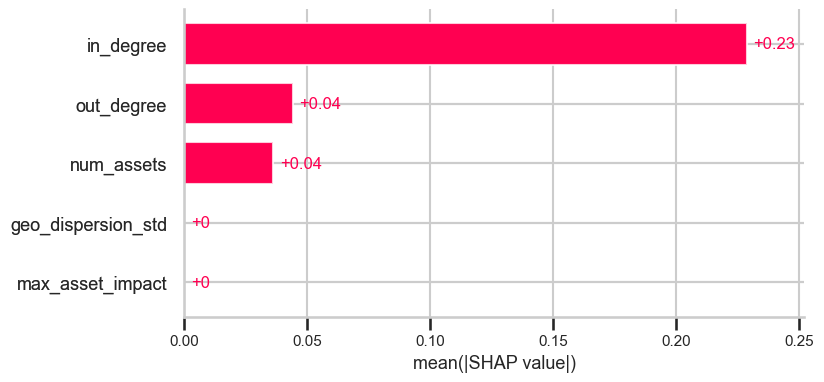

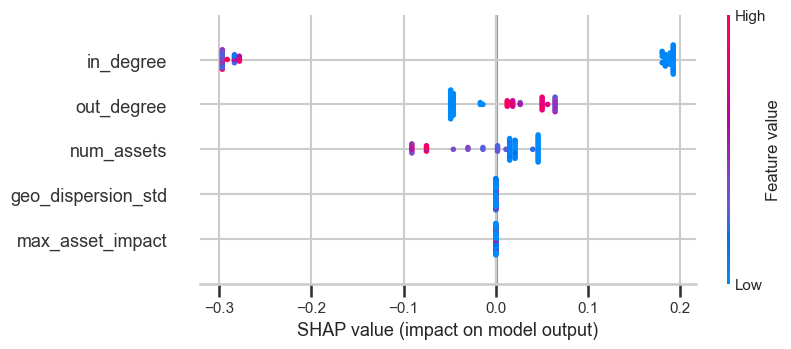

In [190]:
y = df_model["VaR_99"]  # or "VaR_95", "ES_99", "ES_95"

# Standardize charateristics
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
n_bootstrap = 10
shap_matrix_list = []

# Create a SHAP matrix
for seed in range(n_bootstrap):
    model = lgb.LGBMRegressor(
        objective="quantile",
        alpha=0.1,  #tau = 0.1, adjust to 0.5 according to research focus
        learning_rate=0.01,
        num_leaves=5,
        min_child_samples=10,
        max_depth=3,
        lambda_l1=1.0,
        lambda_l2=5.0,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=seed
    )
    
    model.fit(X_scaled, y)
    
    # Explanatin of SHAP
    explainer = shap.Explainer(model, feature_names=features, approximate=True)
    shap_values = explainer(X_scaled)
    shap_matrix_list.append(shap_values.values)

# Calculate the average SHAP matrix
avg_shap_values = np.mean(np.stack(shap_matrix_list, axis=0), axis=0)

#Construct a stable version of the SHAP object (using the last explainer and replacing with the average value)
stable_shap_values = shap.Explanation(
    values=avg_shap_values,
    base_values=explainer.expected_value,
    data=X_scaled,
    feature_names=features
)

# Plot: Features importance & Beeswarm
shap.plots.bar(stable_shap_values, max_display=10)
shap.plots.beeswarm(stable_shap_values, max_display=10)